# Next POI prediction through Graph Neural Networks
Student: Giancarlo Tedesco


Matricola: 2057231

In [1]:
!pip install pytorch-lightning

# Install  Pytorch Geometric.
import torch
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [2]:
try:
    import google.colab
    on_colab = True
except ImportError:
    on_colab = False

print("Running on Colab:", on_colab)

Running on Colab: True


## Import section

In [3]:
import os
import pickle
import random
import gdown

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import train_test_split
from torch import Tensor, nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader, LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch_sparse import SparseTensor, matmul
from torchmetrics.retrieval import RetrievalMRR

In [4]:
use_gpu = True
device = torch.device(
    "cuda" if use_gpu and torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset import

### Dataset download section

In the following cell, depending on the workspace (Colab or locally), required files are downloaded. Specifically:
1. **Dataset file:** the zip file containing the all the documents required for building up the dataset
2. **Precomputed files:** files such as models checkpoint and CSV metrics after some training time (more than hours) to better evaluate results and skip time consuming cell executions.
   
**N.B: All these files are computed locally starting from the given notebook. With the exception of the dataset file, everything else was calculated through this notebook**

In [5]:
if on_colab:
    print("Downloading dataset_tsmc2014.zip")
    !wget http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip
    print("Extracting dataset_tsmc2014.zip")
    !unzip dataset_tsmc2014.zip


    # Dowloading the files
    files_id = '10ILXVeIFBptyA5eR3dPJjsaLq899EvMf'
    file_output = 'related_files.zip'
    files_url = 'https://drive.google.com/uc?id='+ files_id + '&export=download&confirm=t'

    print("Downloading related files")
    gdown.download(files_url, file_output, quiet=False)
    print("Extracting the zip")
    !unzip related_files.zip
    print("Deleting the previous downloaded zips")
    os.remove("dataset_tsmc2014.zip")
    os.remove("related_files.zip")
    print('--Deleted')

else:
    import wget
    import zipfile

    if os.path.exists("dataset_tsmc2014"):
        print("File dataset_tsmc2014.zip already downloaded and extracted.")
    else:
        print("Downloading dataset_tsmc2014.zip")
        wget.download("http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip")
        print("Downloaded dataset_tsmc2014.zip")

        with zipfile.ZipFile("dataset_tsmc2014.zip", 'r') as zip_ref:
            zip_ref.extractall()
        print("Extracted dataset_tsmc2014.zip")

        print('Deleting the previous downloaded zip')
        os.remove("dataset_tsmc2014.zip")
        print('--Deleted')

--2024-07-09 22:04:54--  http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip
Resolving www-public.tem-tsp.eu (www-public.tem-tsp.eu)... 157.159.10.107, 2001:660:3203:100:1:0:80:107
Connecting to www-public.tem-tsp.eu (www-public.tem-tsp.eu)|157.159.10.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25546284 (24M) [application/zip]
Saving to: ‘dataset_tsmc2014.zip’

dataset_tsmc2014.zi 100%[===================>]  24.36M  5.67MB/s    in 4.6s    

2024-07-09 22:05:00 (5.32 MB/s) - ‘dataset_tsmc2014.zip’ saved [25546284/25546284]

Extracting dataset_tsmc2014.zip
Archive:  dataset_tsmc2014.zip
   creating: dataset_tsmc2014/
  inflating: dataset_tsmc2014/dataset_TSMC2014_NYC.txt  
  inflating: dataset_tsmc2014/dataset_TSMC2014_readme.txt  
  inflating: dataset_tsmc2014/dataset_TSMC2014_TKY.txt  


Downloading...
From: https://drive.google.com/uc?id=10ILXVeIFBptyA5eR3dPJjsaLq899EvMf&export=download&confirm=t
To: /content/related_files.zip
100%|██████████| 84.4M/84.4M [00:01<00:00, 42.4MB/s]


Extracting the zip
Archive:  related_files.zip
  inflating: graphSAGE.ckpt          
  inflating: LightGCN.ckpt           
   creating: logs/GNN-Link-Prediction/
   creating: logs/GNN-Link-Prediction/version_23/
  inflating: logs/GNN-Link-Prediction/version_23/metrics.csv  
   creating: logs/LightGCN-ReccSys/
   creating: logs/LightGCN-ReccSys/version_42/
  inflating: logs/LightGCN-ReccSys/version_42/metrics.csv  
Deleting the previous downloaded zips
--Deleted


### Dataframe building

In [6]:
columns = ['User ID',
           'Venue ID',
           'Venue category ID',
           'Venue category name',
           'Latitude',
           'Longitude',
           'Timezone',
           'UTC time']

df = pd.read_csv('dataset_tsmc2014/dataset_TSMC2014_NYC.txt',  sep='\t', encoding='latin-1', names=columns)

df.head()

,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Timezone,UTC time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012


#### Dataframe analysis

Check if there are some null values in the data.
Moreover, check dimension of the dataframe

In [7]:
column_null_counts = df.isnull().sum()  # Count of 'null' values in each column
print(f"Number of rows: {df.shape[0]} | Number of columns: {df.shape[1]} ")
print("\nSummary of 'null' values in each column:")
print(column_null_counts)

Number of rows: 227428 | Number of columns: 8 

Summary of 'null' values in each column:
User ID                0
Venue ID               0
Venue category ID      0
Venue category name    0
Latitude               0
Longitude              0
Timezone               0
UTC time               0
dtype: int64


#### Preprocessing steps

In [8]:
# Filter out users with fewer than 26 check-ins
user_checkin_counts = df['User ID'].value_counts()
valid_users = user_checkin_counts[user_checkin_counts >= 26].index
df_filtered_users = df[df['User ID'].isin(valid_users)]

# Sort each user's check-in records according to timestamp order
df_sorted = df_filtered_users.sort_values(by=['User ID', 'UTC time'])

# Display the sorted DataFrame
df_sorted

,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Timezone,UTC time
13737,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,Fri Apr 13 15:41:41 +0000 2012
25849,1,3fd66200f964a520e9e61ee3,4bf58dd8d48988d147941735,Diner,40.733763,-74.006264,-240,Fri Apr 20 01:49:26 +0000 2012
145520,1,43a52546f964a520532c1fe3,4bf58dd8d48988d1ed931735,Airport,40.645089,-73.784523,-240,Fri Aug 10 16:40:07 +0000 2012
145542,1,4acb79dff964a520e5c320e3,4bf58dd8d48988d1cc941735,Steakhouse,40.640856,-73.789201,-240,Fri Aug 10 17:05:07 +0000 2012
195850,1,3fd66200f964a52048e31ee3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.734895,-74.003155,-300,Fri Dec 14 17:55:32 +0000 2012
...,...,...,...,...,...,...,...,...
180668,1083,42911d00f964a520f5231fe3,4bf58dd8d48988d129951735,Train Station,40.750795,-73.993576,-300,Wed Nov 21 20:36:17 +0000 2012
164446,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-240,Wed Oct 24 11:18:02 +0000 2012
154062,1083,4a53d9a7f964a520c7b21fe3,4bf58dd8d48988d124941735,Office,40.745518,-73.992351,-240,Wed Sep 05 18:08:42 +0000 2012
154190,1083,42911d00f964a520f5231fe3,4bf58dd8d48988d129951735,Train Station,40.750795,-73.993576,-240,Wed Sep 05 21:17:39 +0000 2012


In [9]:
# Visualization of a sample user's check-ins
num = 293   # User ID with the most check-ins
count_rows_with_user_id_1 = df_sorted[df_sorted['User ID'] == num].shape[0]

print(f'Number of rows with User ID = {num}: {count_rows_with_user_id_1}')

Number of rows with User ID = 293: 2697


In [10]:
# Reassign the venue IDs and venue category IDs (because here the IDs didn't start at 0) by starting from 0 for each column
df_1 = df_sorted.copy()

venues = df_sorted['Venue ID'].unique()
categories = df_sorted['Venue category ID'].unique()
new_ids = list(range(len(venues)))
new_cat_ids = list(range(len(categories)))
mapping = dict(zip(venues, new_ids))
mapping_cat = dict(zip(categories, new_cat_ids))

df_1['Venue ID'] = df_1['Venue ID'].map(mapping)
df_1['Venue category ID'] = df_1['Venue category ID'].map(mapping_cat)

In [11]:
# Localizes the 'UTC time' column of a DataFrame to the timezone specified in the 'Timezone' column
def apply_Timezone(data_df: pd.DataFrame):
    # Convert the UTC time column to datetime type
    data_df['UTC time'] = pd.to_datetime(
        data_df['UTC time'], format='%a %b %d %H:%M:%S +0000 %Y')

    # Convert the timezone offset to timedelta
    data_df['Timezone'] = pd.to_timedelta(data_df['Timezone'], unit='m')

    # Apply the timezone offset to the UTC time
    data_df['Localized time'] = data_df['UTC time'] + data_df['Timezone']

    # Format the 'Localized time' column
    data_df['Localized time'] = data_df['Localized time'].dt.strftime(
        '%Y-%m-%d %H:%M')   # second precision is dropped

    # Drop the timezone column
    data_df.drop(columns=['Timezone', 'UTC time'], inplace=True)

    # Sort the DataFrame by 'User ID' and 'Localized time'
    data_df = data_df.sort_values(by=['User ID', 'Localized time'])

    return data_df

In [12]:
df_1 = apply_Timezone(df_1).reset_index(drop=True)

In [13]:
# Display some statistics of the data
n_users = df_1['User ID'].nunique()
n_venues = df_1['Venue ID'].nunique()
n_categories = df_1['Venue category ID'].nunique()
n_names = df_1['Venue category name'].nunique()
print(f"Number of users: {n_users} | Number of venues: {n_venues} | Number of categories: {n_categories} | Number of category names: {n_names}")
n_different_times = df_1['Localized time'].nunique()
print(f"Number of different time-slots: {n_different_times}")
print(f"Number of check-ins: {df_1.shape[0]}")
df_1.head(11)

Number of users: 1083 | Number of venues: 38333 | Number of categories: 400 | Number of category names: 251
Number of different time-slots: 129045
Number of check-ins: 227428


,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Localized time
0,1,33,4,Seafood Restaurant,40.781558,-73.975792,2012-04-04 19:31
1,1,16,14,American Restaurant,40.784018,-73.974524,2012-04-07 13:42
2,1,52,34,General Entertainment,40.739398,-73.993210,2012-04-08 14:20
3,1,53,8,American Restaurant,40.785677,-73.976498,2012-04-08 16:02
4,1,11,11,Breakfast Spot,40.719929,-74.008532,2012-04-09 12:20
5,1,70,3,Steakhouse,40.734276,-73.993525,2012-04-09 20:24
6,1,56,36,Bar,40.775986,-73.979528,2012-04-09 23:36
7,1,0,0,Mexican Restaurant,40.717888,-74.005668,2012-04-10 12:21
8,1,14,13,Coffee Shop,40.720087,-74.003961,2012-04-12 13:19
9,1,0,0,Mexican Restaurant,40.717888,-74.005668,2012-04-13 11:41


After time pre-processing in the order of minutes, certain check-ins were found to be duplicates of the originals, likely stemming from system issues such as registration failures

In [14]:
# Drop duplicated rows
print(f"Number of rows before dropping duplicates: {df_1.shape[0]}")
df_1 = df_1.drop_duplicates()
print(f"Number of rows after dropping duplicates: {df_1.shape[0]}")

Number of rows before dropping duplicates: 227428
Number of rows after dropping duplicates: 226809


Extract two separate dataframes for User IDs and POIs info

In [15]:
user_info = df_1[['User ID', 'Venue ID', 'Localized time']
                 ].copy().reset_index(drop=True)
poi_info = df_1[['Venue ID', 'Latitude', 'Longitude', 'Venue category ID']].drop_duplicates(
    ['Venue ID']).sort_values(by=['Venue ID']).reset_index(drop=True)

(TL;DR) Remapping of the timesteps not used

Timesteps are remapped into an alternative representation: the approach involves establishing the oldest record as the initial reference time-point for each user, after which the new time representation is defined as the temporal difference in minutes between the starting time and the current recorded time. This method aims to enhance the model's ability to handle temporal information effectively.

In [16]:
user_info['Localized time'] = pd.to_datetime(user_info['Localized time'])   # Convert to datetime type

# Initialize a new column
user_info['mins since start'] = 0

# Find the oldest timestamp for each user
for user_id in user_info['User ID'].unique():
    oldest_timestamp = user_info[user_info['User ID']
                                 == user_id]['Localized time'].min()
    user_info.loc[user_info['User ID'] == user_id, 'mins since start'] = (
        (user_info[user_info['User ID'] == user_id]['Localized time'] - oldest_timestamp).dt.total_seconds() / 60).round().astype(int) + 1

user_info.drop(columns=['Localized time'], inplace=True)

user_info.head()

,User ID,Venue ID,mins since start
0,1,33,1
1,1,16,3972
2,1,52,5450
3,1,53,5552
4,1,11,6770


## User-POI Graph

In [17]:
# Create a HeteroData object for the bipartite graph
U_P_graph = HeteroData()

undirected = T.ToUndirected()

# --- Node Features ---

# User nodes (no explicit features)
user_ids = torch.tensor(user_info['User ID'].unique(), dtype=torch.long)
U_P_graph['user'].num_nodes = len(user_ids)

# POI nodes (with features)
poi_ids = torch.tensor(poi_info['Venue ID'].unique(), dtype=torch.long)
U_P_graph['poi'].num_nodes = len(poi_ids)

# Map Venue IDs to indices for feature lookup
poi_id_to_idx = {venue_id.item(): idx for idx, venue_id in enumerate(poi_ids)}

# Create POI feature tensor (Venue Category ID, Latitude, Longitude)
poi_features = []
for _, row in poi_info.iterrows():
    venue_id = row['Venue ID']
    features = torch.tensor(
        [row['Venue category ID'], row['Latitude'], row['Longitude']], dtype=torch.float)
    poi_features.append(features)
poi_features = torch.stack(poi_features)
U_P_graph['poi'].x = poi_features

# --- Edge Indices ---

edge_index_user_to_poi = []
for _, row in user_info.iterrows():
    user_idx = torch.where(user_ids == row['User ID'])[0].item()
    poi_idx = poi_id_to_idx[row['Venue ID']]
    edge_index_user_to_poi.append([user_idx, poi_idx])

# Node Indexing ---
U_P_graph['user'].node_idx = torch.arange(U_P_graph['user'].num_nodes)
U_P_graph['poi'].node_idx = torch.arange(U_P_graph['poi'].num_nodes)

edge_index_user_to_poi = torch.tensor(
    edge_index_user_to_poi, dtype=torch.long).t().contiguous()
U_P_graph['user', 'visits', 'poi'].edge_index = edge_index_user_to_poi

U_P_graph = undirected(U_P_graph)

print("Final edge indices pointing from users to POIs:")
print(edge_index_user_to_poi)

Final edge indices pointing from users to POIs:
tensor([[    0,     0,     0,  ...,  1082,  1082,  1082],
        [   33,    16,    52,  ...,  3857,  2603, 10053]])


In [18]:
# Step needed for the HeteroData object to be validated: check if the graph is correctly constructed
print("Validating the HeteroData: ", U_P_graph.validate(raise_on_error=True))

# Visualize the graph structure
print("\nGraph structure: \n", U_P_graph)

Validating the HeteroData:  True

Graph structure: 
 HeteroData(
  user={
    num_nodes=1083,
    node_idx=[1083],
  },
  poi={
    num_nodes=38333,
    x=[38333, 3],
    node_idx=[38333],
  },
  (user, visits, poi)={ edge_index=[2, 226809] },
  (poi, rev_visits, user)={ edge_index=[2, 226809] }
)


In [19]:
# To upload locally already computed graph
if (on_colab==False):
    choice = "Load"

    if choice == "Save":
        if os.path.exists("U_P_graph.pickle"):
            print("File U_P_graph.pickle already exists. Overwrite? (Y/N)")
            in_key = input()
            if in_key in ("Y", "y"):
                with open("U_P_graph.pickle", "wb") as f:
                    pickle.dump(U_P_graph, f)
                print("U_P_graph.pickle saved")
            else:
                print("U_P_graph.pickle discarded")
        else:
            with open("U_P_graph.pickle", "wb") as f:
                pickle.dump(U_P_graph, f)
            print("Saving U_P_graph.pickle")
    elif choice == "Load":
        with open("U_P_graph.pickle", "rb") as f:
            U_P_graph = pickle.load(f)
        print("U_P_graph.pickle loaded")
else:
        print("Cell skipped")

Cell skipped


### Subgraph visual example

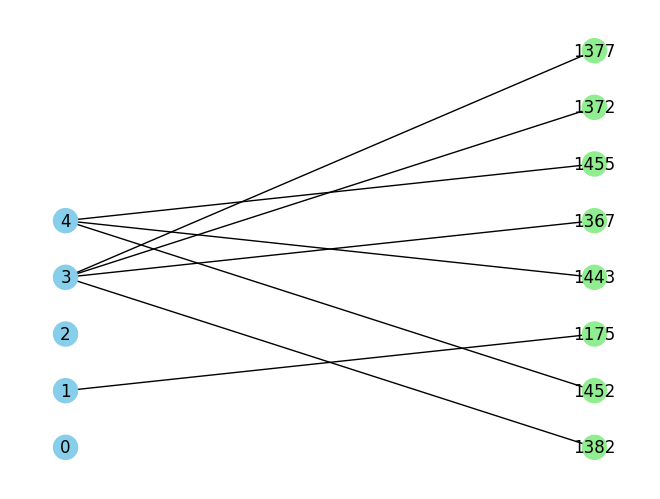

In [20]:
# Create a NetworkX bipartite graph
B = nx.Graph()
first_five_users = range(5)  # First 5 user nodes

edge_index_user_to_poi = U_P_graph['user', 'visits', 'poi'].edge_index
user_ids = U_P_graph['user'].node_idx

# Get all POIs visited by the first 5 users
visited_pois = set()
for i in first_five_users:
    user_visits = edge_index_user_to_poi[1][edge_index_user_to_poi[0] == i]
    visited_pois.update(user_visits.tolist())

# Count the frequency of each POI visit
poi_visit_counts = {poi: 0 for poi in visited_pois}
for i in first_five_users:
    user_visits = edge_index_user_to_poi[1][edge_index_user_to_poi[0] == i]
    for poi in user_visits:
        poi_visit_counts[poi.item()] += 1

# Select the top 8 most commonly visited POIs
common_pois = sorted(
    poi_visit_counts, key=poi_visit_counts.get, reverse=True)[:8]
poi_indices = [len(user_ids) + poi for poi in common_pois]

# Add user and POI nodes to the graph
B.add_nodes_from(first_five_users, bipartite=0, label='user')
B.add_nodes_from(poi_indices, bipartite=1, label='poi')

# Add edges to the graph
for i in range(edge_index_user_to_poi.size(1)):
    user, poi = edge_index_user_to_poi[:, i].tolist()
    if user < 5 and poi in common_pois:  # Only add edges for the first 5 users and common POIs
        B.add_edge(user, len(user_ids) + poi)

# Draw the bipartite graph
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(
    first_five_users))  # Put user nodes on the left
pos.update((n, (2, i)) for i, n in enumerate(
    poi_indices))       # Put poi nodes on the right

nx.draw(B, pos, with_labels=True, node_color=[
        'skyblue' if n < 5 else 'lightgreen' for n in B.nodes])
plt.show()

## GRAPHSage Architecture

### Data Loaders
*Edge-level training splits and Mini-batch loaders*

The `RandomLinkSplit` transform splits the dataset for training, validation, and testing purposes. The splits are created with specified criteria such as division between edges for training or message-passing, etc..

`LinkNeighborLoader` is a link-based data loader. This approach is very convenient because it allows for efficient handling of large graphs by focusing on relevant subgraphs, reducing computational overhead. By iteratively sampling neighbors, it maintains the structural integrity of the graph, ensuring that the generated subgraph is representative of the local topology. This method is particularly beneficial for tasks such as link prediction, where understanding the context around specific edges is crucial.

In [21]:
# Create a RandomLinkSplit transform for Splitting Data
transform = RandomLinkSplit(
    num_val=0.1,    # 10% of the data for validation
    num_test=0.1,   # 10% of the data for testing
    # 30% of edges for supervised training (70% for message-passing)
    disjoint_train_ratio=0.3,
    # 2 negative edges per positive sample (2:1 ratio) for evaluation
    neg_sampling_ratio=2,
    # Do not add negative samples to the graph for training
    add_negative_train_samples=False,
    # Specify the edge type for splitting
    edge_types=('user', 'visits', 'poi'),
    is_undirected=True  # Ensure the graph is undirected
)

train_data, val_data, test_data = transform(U_P_graph)

# Create a LinkNeighborLoader Data Loaders for training, validation, and testing
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[30, 20],
    neg_sampling_ratio=10,
    edge_label_index=(('user', 'visits', 'poi'),
                      train_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=train_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=True,
)

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(('user', 'visits', 'poi'),
                      test_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=test_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=False,
)

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(('user', 'visits', 'poi'),
                      val_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=val_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=False,
)

# Sample data from the loaders to check
sampled_train_data = next(iter(train_loader))
sampled_test_data = next(iter(test_loader))
sampled_val_data = next(iter(val_loader))

print("Sampled data from the train loader:", sampled_train_data)
print("Sampled data from the test loader:", sampled_test_data)
print("Sampled data from the val loader:", sampled_val_data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Sampled data from the train loader: HeteroData(
  user={
    num_nodes=1083,
    node_idx=[1083],
    n_id=[1083],
  },
  poi={
    num_nodes=14068,
    x=[14068, 3],
    node_idx=[14068],
    n_id=[14068],
  },
  (user, visits, poi)={
    edge_index=[2, 65014],
    edge_label=[1408],
    edge_label_index=[2, 1408],
    e_id=[65014],
    input_id=[128],
  },
  (poi, rev_visits, user)={
    edge_index=[2, 28030],
    e_id=[28030],
  }
)
Sampled data from the test loader: HeteroData(
  user={
    num_nodes=1000,
    node_idx=[1000],
    n_id=[1000],
  },
  poi={
    num_nodes=3926,
    x=[3926, 3],
    node_idx=[3926],
    n_id=[3926],
  },
  (user, visits, poi)={
    edge_index=[2, 11922],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[11922],
    input_id=[128],
  },
  (poi, rev_visits, user)={
    edge_index=[2, 5590],
    e_id=[5590],
  }
)
Sampled data from the val loader: HeteroData(
  user={
    num_nodes=994,
    node_idx=[994],
    n_id=[994],
  },
  poi={
    nu

### Network initialization
The convolution graph network is based on the SAGE convolution.
SageConv uses the average of the representations of the neighbors, normalized by the degree of each neighbor, as the aggregate representation. This allows it to capture more fine-grained information about the graph structure.
The default aggregation function for SAGEConv is **mean** aggregation. This function computes the average of the neighboring nodes' features, representing the second term in the update process. The update step itself involves a linear combination of the aggregated neighbors' representation and the newly transformed representation of the current node, denoted by the first term:
$$
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j
$$

The architecture presents 3 convolutional layers, with a dropout between the first two convolutions and ReLU as activation function.

In [22]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.dropout(out)  # Apply dropout
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        return out

# Classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_poi: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_poi = x_poi[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_poi).sum(dim=-1)

### Lightning Module

The following cell defines the `Model` class from `pl.LightningModule`, using PyTorch Lightning. The key components and their purposes are illustrated below:

1. **Initialization (`__init__` method):**
   - **Linear and Embedding Layers:** Initializes a linear layer for POI (point of interest) features and embedding layers for user and POI nodes to convert them into a higher-dimensional space.
   - **Loss and Metrics:** Sets up the loss function (Binary Cross-Entropy with Logits) and metrics (Accuracy and Mean Reciprocal Rank).
   - **GNN Instantiation:** Creates a homogeneous GNN and converts it into a heterogeneous variant to handle different types of nodes and edges in the graph.
   - **Classifier:** Instantiates a classifier to predict the edge labels between user and POI nodes.

2. **Forward Pass (`forward` method):**
   - **Feature Matrices (`x_dict`):** Constructs feature matrices for users and POIs using embeddings and linear transformations.
   - **Edge Index Dictionary:** Passes the feature matrices and edge indices through the GNN.
   - **Prediction:** Uses the classifier to predict edge labels based on the processed feature matrices.

3. **Training, Validation, and Test Steps:**
   - **Common Step (`_common_step` method):** Executes a forward pass, computes the loss, accuracy, and MRR for a given batch, and logs these metrics.
   - **Specific Steps:** The `training_step`, `validation_step`, and `test_step` methods each call `_common_step` with appropriate phase labels.

4. **Optimizer Configuration (`configure_optimizers` method):**
   - **Optimizer:** Sets up the Adam optimizer with a learning rate of 0.001.

In [23]:
class Model(pl.LightningModule):
    def __init__(self, hidden_channels):
        super().__init__()
        # self.save_hyperparameters()
        self.poi_lin = torch.nn.Linear(3, hidden_channels)      # Linear layer for POI features
        self.user_emb = torch.nn.Embedding(
            U_P_graph["user"].num_nodes, hidden_channels)       # Embedding layer for user nodes
        self.poi_emb = torch.nn.Embedding(
            U_P_graph["poi"].num_nodes, hidden_channels)        # Embedding layer for POI nodes
        self.loss_fn = nn.BCEWithLogitsLoss()                   # Loss function
        self.accuracy = torchmetrics.Accuracy(task="binary")    # Accuracy metric
        self.retrieval_mrr = RetrievalMRR()                     # MRR metric

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=U_P_graph.metadata())

        # Instantiate the classifier:
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        # `x_dict` holds feature matrices of all node types
        x_dict = {
            "user": self.user_emb(data["user"].node_idx),
            "poi": self.poi_lin(data["poi"].x) + self.poi_emb(data["poi"].node_idx),
        }

        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        # Predict the edge labels
        pred = self.classifier(
            x_dict["user"],
            x_dict["poi"],
            data["user", "visits", "poi"].edge_label_index,
        )
        return pred

    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, "val")
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._common_step(batch, "test")
        return loss

    def _common_step(self, batch, phase: str = 'train'):
        out = self.forward(batch)
        ground_truth = batch['user', 'visits', 'poi'].edge_label.int()
        loss = self.loss_fn(input=out, target=ground_truth.float())
        accuracy = self.accuracy(out, ground_truth)
        indexes = torch.arange(len(ground_truth))
        mrr = self.retrieval_mrr(out, ground_truth, indexes)
        self.log(f"{phase}_loss", loss, batch_size=ground_truth.size()[0], prog_bar=True)
        self.log(f"{phase}_acc", accuracy, batch_size=ground_truth.size()[0])
        self.log(f"{phase}_MRR", mrr, batch_size=ground_truth.size()[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

This cell sets up the configuration for training the GNN model, utilizing `Trainer` class from Lightning. To prevent overfitting, the usage of the EarlyStop callback is adopted: keeps trace of the validation accuracy and stops training if the accuracy does not improve by at least `min_delta` (0.00) for a specified number of epochs (`patience` = 3).

Moreover, CSVLogger is used to log training metrics to CSV files for later analysis.

In [24]:
early_stop_callback = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max")   # Early stopping callback

LOGGER = CSVLogger("logs", name="GNN-Link-Prediction")  # Logger

trainer = pl.Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     devices=1,
                     max_epochs=1,
                     precision=16,
                     logger=LOGGER,
                     log_every_n_steps=5,
                     callbacks=early_stop_callback)

if on_colab:
    model = Model.load_from_checkpoint("graphSAGE.ckpt", hidden_channels=64)    # Load the model
else:
    model = Model(hidden_channels=64)   # Initialize the model

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
# Validate the model before training
trainer.validate(model, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MRR          │    0.3333333432674408     │
│          val_acc          │    0.7966049313545227     │
│         val_loss          │    0.46228936314582825    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.46228936314582825,
  'val_acc': 0.7966049313545227,
  'val_MRR': 0.3333333432674408}]

The training step takes only one epoch starting from the loaded checkpoint. This because the purpose is to illustrate the the correctness of the implementation and to avoid long time consuming computations: the "checkpointed" model is the final training model after 10 epochs and took ~1.30hr to be computed. Then, the following training will perform just another extra epoch starting from the previous model.

In [26]:
# Train the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | poi_lin       | Linear            | 256    | train
1 | user_emb      | Embedding         | 69.3 K | train
2 | poi_emb       | Embedding         | 2.5 M  | train
3 | loss_fn       | BCEWithLogitsLoss | 0      | train
4 | accuracy      | BinaryAccuracy    | 0      | train
5 | retrieval_mrr | RetrievalMRR      | 0      | train
6 | gnn           | GraphModule       | 49.5 K | train
7 | classifier    | Classifier        | 0      | train
------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.290    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [27]:
if on_colab:
    print("Cell skipped")
else:
    trainer.save_checkpoint("graphSAGE.ckpt")

Cell skipped


In [28]:
# Test the model
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MRR          │    0.3333333432674408     │
│         test_acc          │     0.762595534324646     │
│         test_loss         │    0.5273450613021851     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5273450613021851,
  'test_acc': 0.762595534324646,
  'test_MRR': 0.3333333432674408}]

### Plotting results

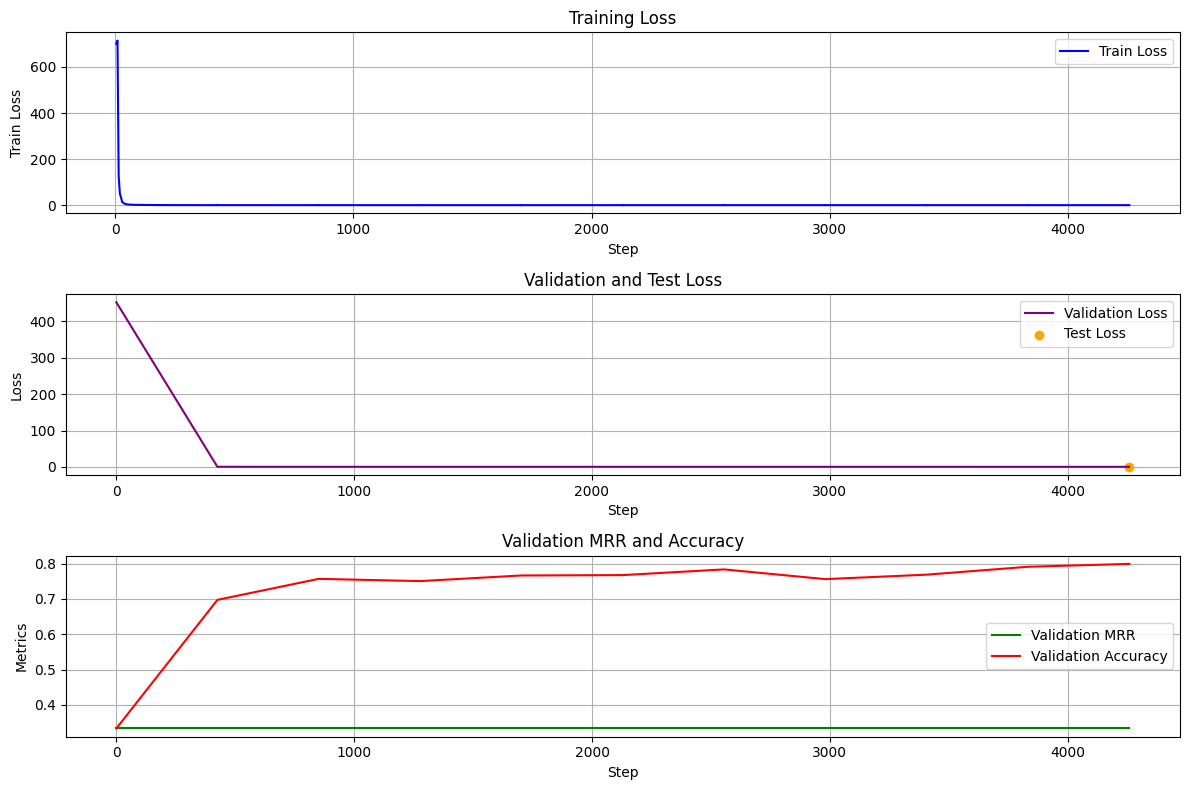

In [29]:
# Read the CSV file
file_path = "logs/GNN-Link-Prediction/version_23/metrics.csv"
df = pd.read_csv(file_path)

# Filter out the rows where the validation and test metrics are present
val_metrics = df.dropna(subset=['val_loss'])
test_metrics = df.dropna(subset=['test_loss'])

# Plotting train loss and other metrics
plt.figure(figsize=(12, 8))

# Plot train loss
plt.subplot(3, 1, 1)
plt.plot(df['step'], df['train_loss'], label='Train Loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss and test loss using scatter plots
plt.subplot(3, 1, 2)
if not val_metrics.empty:
    plt.plot(val_metrics['step'], val_metrics['val_loss'], label='Validation Loss', color='purple')
if not test_metrics.empty:
    plt.scatter(test_metrics['step'], test_metrics['test_loss'], label='Test Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation and Test Loss')
plt.legend()
plt.grid(True)

# Plot validation MRR and validation accuracy
plt.subplot(3, 1, 3)
plt.plot(val_metrics['step'], val_metrics['val_MRR'], label='Validation MRR', color='green')
plt.plot(val_metrics['step'], val_metrics['val_acc'], label='Validation Accuracy', color='red')
plt.xlabel('Step')
plt.ylabel('Metrics')
plt.title('Validation MRR and Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## LightGCN Architecture

### Data loaders
**N.B:** The use of built-in functions lead to some issues with CUDA-AssertionTrigger due to the splitting logic of the methods. Hence, a naive index-based split is performed to avoid the issue.

The cells below prepare the edge indices and creates data loaders for training, validation, and testing the graph model. Here is a detailed explanation of the steps involved:

1. **Extract Edge Indices:** Retrieves the edge indices for the 'user' to 'poi' interactions from the graph.

2. **Count Nodes and Interactions:**

3. **Split Indices:** Splits the interactions into training, validation, and testing sets.
     - First split: 70% of the interactions for training, 30% for testing.
     - Second split: Splits the 30% test set into half for validation and half for testing.

4. **Create Edge Index Sets:** Creates separate edge index tensors for training, validation, and testing.

5. **Data Loaders:** Creates data loaders for batching and shuffling edge indices during training and evaluation.

6. **Sparse Tensors:** Converts edge indices to sparse tensor format for efficient processing.

In [30]:
edge_index = U_P_graph['user', 'visits', 'poi'].edge_index  # Edge indices

num_interactions = edge_index.shape[1]              # Number of interactions, namely poi visits
all_indices = [i for i in range(num_interactions)]  # All indices, namely all edges

# HYPERPARAMETERS
NUM_USERS = U_P_graph['user'].num_nodes # Number of user nodes
NUM_POIS = U_P_graph['poi'].num_nodes   # Number of POI nodes

EMBEDDING_DIM = 128                     # Embedding dimension
NUM_LAYERS = 3                          # Number of layers
LAMBDA_VAL = 1e-6                       # Regularization parameter for the loss function

In [31]:
train_indices, test_indices = train_test_split(
    all_indices, test_size=0.3, random_state=2057231)   # Split the indices into train set and a temporary test set,
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=2057231)  # Split the test indices into validation and test sets

train_edge_index = edge_index[:, train_indices]     # Train edge indices, filtered by train indices mask
val_edge_index = edge_index[:, val_indices]        # Validation edge indices, filtered by validation indices mask
test_edge_index = edge_index[:, test_indices]   # Test edge indices, filtered by test indices mask

The data loader is the standard loader from Pytorch geometric package, which merges data objects from a torch_geometric.data.Dataset to a mini-batch.

In [32]:
train_loader = DataLoader(train_edge_index.T, batch_size=1028, shuffle=True)    # Train data loader
val_loader = DataLoader(val_edge_index.T, batch_size=1028, shuffle=False)       # Validation data loader
test_loader = DataLoader(test_edge_index.T, batch_size=1028, shuffle=False)     # Test data loader

In this cell, sparse tensors are implemented for the training, testing, and validation edge indices. This process is crucial for the efficient operation of the LightGCN (Light Graph Convolution Network) architecture:

- **train_sparse_edge_index**: This sparse tensor represents the training edges. It is created using the `SparseTensor` class, which requires the row and column indices of the edges. The column indices are offset by `NUM_USERS` to differentiate between user and item nodes.
- **test_sparse_edge_index**: Similarly, this sparse tensor represents the testing edges.
- **validation_sparse_edge_index**: This sparse tensor represents the validation edges.


*SparseTensor*: A data structure that efficiently represents a sparse matrix. In this context, it helps to save memory and computation by only storing and processing non-zero elements of the adjacency matrix.

Using sparse tensors is beneficial because:
1. **Memory Efficiency**: Sparse tensors store only non-zero elements, significantly reducing memory usage when dealing with large graphs.
2. **Computational Efficiency**: Operations on sparse tensors are optimized to skip zero entries, making computations faster.
3. **Scalability**: Sparse tensor operations scale better with the size of the graph, enabling the model to handle large datasets effectively.

In [33]:
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1]+NUM_USERS,
                                       sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))       # Train sparse edge index
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1]+NUM_USERS,
                                      sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))        # Test sparse edge index
validation_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1]+NUM_USERS,
                                            sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))  # Validation sparse edge index

In [34]:
print(train_sparse_edge_index)
print(test_sparse_edge_index)
print(validation_sparse_edge_index)

SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1083,  1083,  1084,  ..., 39412, 39414, 39415]),
             size=(39416, 39416), nnz=158766, density=0.01%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1090,  1093,  1093,  ..., 35585, 37987, 39410]),
             size=(39416, 39416), nnz=34022, density=0.00%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1083,  1093,  1093,  ..., 39407, 39410, 39413]),
             size=(39416, 39416), nnz=34021, density=0.00%)


### Network Initialization
LightGCN is a simplified and efficient variant of graph convolutional networks (GCNs) specifically designed for collaborative filtering tasks, such as recommender systems. Specifically, LightGCN learns user and item embeddings by linearly propagating them on the user-item interaction graph, and uses the weighted sum of the embeddings learned at all layers as the final embedding. One of the key reasons for using sparse tensors in LightGCN is to handle large-scale data efficiently.

The graph convolution operation for user and items in LightGCN is defined as:
$$
\mathbf{e}_u^{(k+1)} = \sum_{i \in \mathcal{N}_u} \frac{1}{\sqrt{|\mathcal{N}_u|} \sqrt{|\mathcal{N}_i|}} \mathbf{e}_i^{(k)}
$$

$$
\mathbf{e}_i^{(k+1)} = \sum_{u \in \mathcal{N}_i} \frac{1}{\sqrt{|\mathcal{N}_i|} \sqrt{|\mathcal{N}_u|}} \mathbf{e}_u^{(k)}
$$
where $$\frac{1}{\sqrt{|\mathcal{N}_i|} \sqrt{|\mathcal{N}_u|}}$$ is the symmetric normalization term.

The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. The embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ are combined via the following equation:
$$
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
$$

Where $$\alpha_k$$ is an hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings:
$$\hat{y}_{ui} = e_u^Te_i$$

Source: https://arxiv.org/pdf/2002.02126v4

In [35]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=EMBEDDING_DIM, K=NUM_LAYERS, add_self_loops=False):

        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim)  # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim)  # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):

        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)
        all_embs = torch.cat([self.users_emb.weight, self.items_emb.weight]).cuda()
        embs = [all_embs]
        emb_k = all_embs

        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            emb_k = emb_k.cuda()
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)
        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.cpu()
        x = x.cpu()
        return matmul(adj_t, x)

# Define the LightGCNRecSys model because lightning does not support MessagePassing
class LightGCNRecSys(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=EMBEDDING_DIM, K=NUM_LAYERS, add_self_loops=False):
        super().__init__()
        self.model = LightGCN(num_users, num_items,
                              embedding_dim, K, add_self_loops)

    def forward(self, edge_index: SparseTensor):
        users_emb_final, users_emb, items_emb_final, items_emb = self.model(
            edge_index)
        return users_emb_final, users_emb, items_emb_final, items_emb

This function constructs a dictionary mapping users to the items they have positively interacted with, based on the provided edge index. The purpose of this function is to extract and organize positive interactions from the edge index, which represents user-item interactions. This mapping is needed for generating user-specific recommendations and evaluating model performance.

In [36]:
def positive_user_interactions(edge_index):
    user_pos_items = {}                     # Dictionary to store user positive items
    for i in range(edge_index.shape[1]):    # Iterate over the edge index
        user = edge_index[0][i].item()      # Get the user index
        item = edge_index[1][i].item()      # Get the item index
        if user not in user_pos_items:      # If the user is not already in the dictionary, an empty list is created for that user
            user_pos_items[user] = []
        user_pos_items[user].append(item)   # Append the item to the user's positive items

    return user_pos_items

### Lightning Module

The following cell defines the `LightGCNModule` class, which is a PyTorch Lightning module for the LightGCN recommender system. The key components and their purposes are detailed below:

1. **Initialization (`__init__` method):**
   - **Network Setup:** Initializes the LightGCN network with the given number of users, items, embedding dimensions, and layers. It also allows adding self-loops to the graph.

2. **Forward Pass (`forward` method):**
   - **Embedding Propagation:** Takes a sparse tensor as input and propagates embeddings through the LightGCN network. Returns the final and intermediate embeddings for users and items.

3. **Bayesian Personalized Ranking (BPR) Loss (`bpr_loss` method):**
   - **Regularization Loss:** Computes L2 regularization loss on the embeddings.
   - **Positive and Negative Scores:** Calculates scores for positive and negative item interactions.
   - **Loss Calculation:** Combines the scores and regularization loss to compute the final BPR loss.

4. **Training Step (`training_step` method):**
   - **Forward Pass:** Obtains user and item embeddings from the forward pass using the training sparse edge index.
   - **Negative Sampling:** Generates negative samples for the training batch.
   - **Loss Calculation:** Computes the BPR loss using the positive and negative item embeddings.
   - **Logging:** Logs the training loss.

5. **Validation Step (`validation_step` method):**
   - **Forward Pass:** Obtains user and item embeddings from the forward pass using the validation sparse edge index.
   - **Negative Sampling:** Generates negative samples for the validation batch.
   - **Loss Calculation and Metrics:** Computes the BPR loss and calculates accuracy and MRR metrics. Logs these metrics.

6. **Metrics Calculation (`get_metrics` method):**
   - **Forward Pass:** Obtains user and item embeddings from the forward pass.
   - **Rating Matrix:** Computes the rating matrix by multiplying user and item embeddings.
   - **Exclusion of Training Interactions:** Sets the ratings of training interactions to a very low value to exclude them.
   - **Top-K Accuracy:** Calculates accuracy for various values of K by comparing top-K recommendations with ground truth.
   - **Mean Reciprocal Rank (MRR):** Computes the MRR by determining the rank of the correct item in the top-K recommendations.

7. **Optimizer Configuration (`configure_optimizers` method):**
   - **Optimizer:** Sets up the Adam optimizer with a learning rate of 0.001.

BPR Loss Source: https://arxiv.org/pdf/1205.2618

In [37]:
class LightGCNModule(pl.LightningModule):
    def __init__(self, num_users, num_items, embedding_dim, num_layers, add_self_loops=False):
        super().__init__()
        self.network = LightGCNRecSys(
            num_users, num_items, embedding_dim, num_layers, add_self_loops)

    def forward(self, sparse_tensor: SparseTensor):
        users_emb_final, users_emb, items_emb_final, items_emb = self.network(
            sparse_tensor)
        return users_emb_final, users_emb, items_emb_final, items_emb

    def bpr_loss(self, users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
        reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                                 pos_items_emb_0.norm(2).pow(2) +
                                 neg_items_emb_0.norm(2).pow(2))  # L2 loss

        pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
        pos_scores = torch.sum(pos_scores, dim=-1)
        neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
        neg_scores = torch.sum(neg_scores, dim=-1)

        loss = - torch.mean(torch.nn.functional.softplus(
                pos_scores - neg_scores)) + reg_loss

        return loss

    def training_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(
            train_sparse_edge_index)    # Forward pass
        batch = batch.T                 # Transpose the batch for pytorch geometric structure requirements
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])    # Negative sampling: sample negative edges

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]         # Get user embeddings for the user indices
        users_emb_0Loss = users_emb_0[user_indices]                 # Get user weight embeddings for the user indices
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices] # Get item embeddings for the positive item indices
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]         # Get item weight embeddings for the positive item indices
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices] # Get item embeddings for the negative item indices
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]         # Get item weight embeddings for the negative item indices

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculate the loss
        self.log("train_loss", float(f"{loss:.5f}"), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(
            validation_sparse_edge_index)   # Forward pass
        batch = batch.T                     # Transpose the batch for pytorch geometric structure requirements
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])    # Negative sampling: sample negative edges

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]         # Get user embeddings for the user indices
        users_emb_0Loss = users_emb_0[user_indices]                 # Get user weight embeddings for the user indices
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices] # Get item embeddings for the positive item indices
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]         # Get item weight embeddings for the positive item indices
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices] # Get item embeddings for the negative item indices
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]         # Get item weight embeddings for the negative item indices

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculate the loss
        acc, mrr = self.get_metrics(
            val_edge_index, train_edge_index, validation_sparse_edge_index, k=[1, 3, 5])
        self.log("val_loss", float(f"{loss:.5f}"), prog_bar=True)
        for k, v in acc.items():
            self.log(f"val_acc@{k}", float(f"{v:.5f}"))
        self.log("val_mrr", float(f"{mrr:.5f}"))
        return loss

    def test_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(
            test_sparse_edge_index)   # Forward pass
        batch = batch.T                     # Transpose the batch for pytorch geometric structure requirements
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])    # Negative sampling: sample negative edges

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]         # Get user embeddings for the user indices
        users_emb_0Loss = users_emb_0[user_indices]                 # Get user weight embeddings for the user indices
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices] # Get item embeddings for the positive item indices
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]         # Get item weight embeddings for the positive item indices
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices] # Get item embeddings for the negative item indices
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]         # Get item weight embeddings for the negative item indices

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculate the loss
        acc, mrr = self.get_metrics(
            test_edge_index, train_edge_index, test_sparse_edge_index, k=[1, 3, 5])
        self.log("test_loss", float(f"{loss:.5f}"), prog_bar=True)
        for k, v in acc.items():
            self.log(f"test_acc@{k}", float(f"{v:.5f}"))
        self.log("test_mrr", float(f"{mrr:.5f}"))
        return loss

    def get_metrics(self, edge_index, exclude_edge_index, sparse_edge_index, k=[1, 3, 5]):
        _, user_embedding, _, item_embedding = self.forward(sparse_edge_index)  # Get embeddings

        rating = torch.matmul(user_embedding, item_embedding.T) # Calculate ratings

        exclude_users = exclude_edge_index[0].tolist()
        exclude_items = exclude_edge_index[1].tolist()

        rating[exclude_users, exclude_items] = -(1 << 10)   # Exclude training and validation edges from evaluation assignining a large negative value

        users = edge_index[0].unique()
        set_user_pos_items = positive_user_interactions(
            edge_index)  # Positive items in current set

        acc_at_k = {}
        # Get top-k for all k values at once
        _, top_K_items = rating.topk(k=max(k), dim=1)

        ground_truth_items = pad_sequence(
            [torch.tensor(set_user_pos_items[user.item()],
                          device=rating.device) for user in users],
            batch_first=True, padding_value=-1) # Padding: not all users have the same number of positive items (required for casting to tensor)
        r = torch.zeros_like(top_K_items, dtype=torch.bool)

        for i, user_ground_truth in enumerate(ground_truth_items):
            r[i] = torch.isin(top_K_items[i], user_ground_truth)    # Check if the top-k items are in the ground truth

        acc_at_k = {k_value: r[:, :k_value].sum(
            1).float().mean().item() for k_value in k}  # Calculate accuracy at k

        # Calculate MRR
        top_poi = top_K_items[:, 0] # Top item
        ranks = (ground_truth_items == top_poi[:, None]).nonzero(
            as_tuple=True)[1] + 1   # Calculate ranks
        mrr = ((1.0 / ranks[ranks > 0]).sum()) / sum(len(value)
                                                     for value in set_user_pos_items.values())  # Calculate MRR
        return acc_at_k, mrr

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)   # Adam optimizer
        return optimizer

In this section, are configured the early stopping mechanism, a logger, and the trainer itself, followed by instantiating the model.

1. **Early Stopping Callback:**
   The early stopping callbackk monitors the validation loss (`val_loss`) and stops the training process if there is no improvement.

2. **Logger:**
   CSV logger will save training metrics to a CSV file for later analysis.

3. **Trainer Configuration:**
   The PyTorch Lightning Trainer handles the training loop.

Finally, the LightGCN model is initialized.

In [38]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")  # Early stopping callback

LOGGER = CSVLogger("logs", name="LightGCN-ReccSys") # Logger

trainer = pl.Trainer(default_root_dir="/Link_Pred",
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     devices=1,
                     max_epochs=1,
                     precision=16,
                     logger=LOGGER,
                     log_every_n_steps=5,
                     callbacks=early_stop_callback)
if on_colab:
    model = LightGCNModule.load_from_checkpoint("LightGCN.ckpt", num_users=NUM_USERS, num_items=NUM_POIS, embedding_dim=EMBEDDING_DIM, num_layers=NUM_LAYERS, add_self_loops=False)
else:
    model = LightGCNModule(NUM_USERS, NUM_POIS, EMBEDDING_DIM, NUM_LAYERS, False)   # Instantiate the model

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [39]:
# Validate the model before training
trainer.validate(model, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_acc@1         │   0.010160000994801521    │
│         val_acc@3         │    0.03047000803053379    │
│         val_acc@5         │   0.044319991022348404    │
│         val_loss          │    -74.57194519042969     │
│          val_mrr          │   4.999998054699972e-05   │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': -74.57194519042969,
  'val_acc@1': 0.010160000994801521,
  'val_acc@3': 0.03047000803053379,
  'val_acc@5': 0.044319991022348404,
  'val_mrr': 4.999998054699972e-05}]

The training step takes only one epoch starting from the loaded checkpoint. This because the purpose is to illustrate the the correctness of the implementation and to avoid long time consuming computations: the "checkpointed" model is the final training model after 50 epochs and took ~1.1hr to be computed. Then, the following training will perform just another extra epoch starting from the previous model.

In [40]:
# Train the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | network | LightGCNRecSys | 5.0 M  | train
---------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.181    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [41]:
if on_colab:
    print("Cell skipped")
else:
    trainer.save_checkpoint("LightGCN.ckpt")

Cell skipped


In [42]:
# Test the model
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc@1         │   0.009229997172951698    │
│        test_acc@3         │   0.025849994271993637    │
│        test_acc@5         │    0.03692999482154846    │
│         test_loss         │    -76.17462158203125     │
│         test_mrr          │   5.999998757033609e-05   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -76.17462158203125,
  'test_acc@1': 0.009229997172951698,
  'test_acc@3': 0.025849994271993637,
  'test_acc@5': 0.03692999482154846,
  'test_mrr': 5.999998757033609e-05}]

### Plotting results

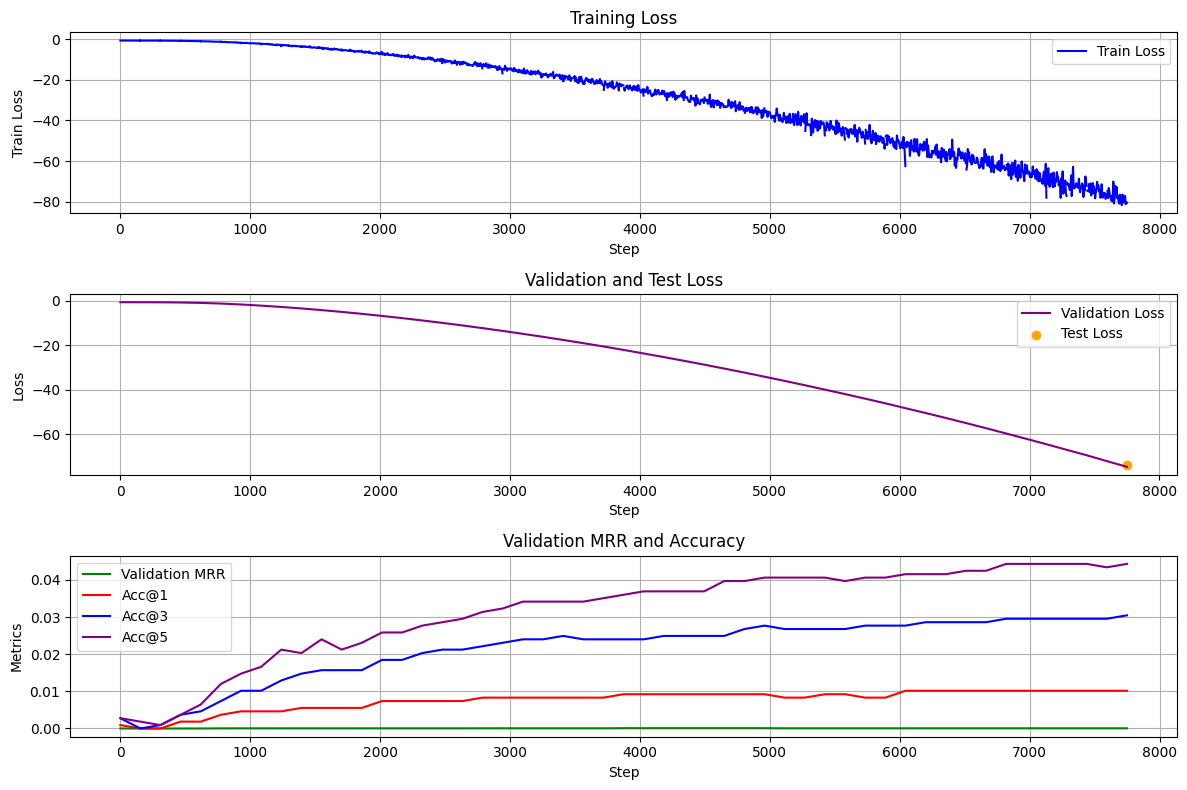

In [43]:
# Read the CSV file
file_path = "logs/LightGCN-ReccSys/version_42/metrics.csv"
df = pd.read_csv(file_path)

# Filter out the rows where the validation and test metrics are present
val_metrics = df.dropna(subset=['val_loss'])
test_metrics = df.dropna(subset=['test_loss'])

# Plotting train loss and other metrics
plt.figure(figsize=(12, 8))

# Plot train loss
plt.subplot(3, 1, 1)
plt.plot(df['step'], df['train_loss'], label='Train Loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss and test loss using scatter plots
plt.subplot(3, 1, 2)
if not val_metrics.empty:
    plt.plot(val_metrics['step'], val_metrics['val_loss'], label='Validation Loss', color='purple')
if not test_metrics.empty:
    plt.scatter(test_metrics['step'], test_metrics['test_loss'], label='Test Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation and Test Loss')
plt.legend()
plt.grid(True)

# Plot validation MRR and validation accuracy
plt.subplot(3, 1, 3)
plt.plot(val_metrics['step'], val_metrics['val_mrr'], label='Validation MRR', color='green')
plt.plot(val_metrics['step'], val_metrics['val_acc@1'], label='Acc@1', color='red')
plt.plot(val_metrics['step'], val_metrics['val_acc@3'], label='Acc@3', color='blue')
plt.plot(val_metrics['step'], val_metrics['val_acc@5'], label='Acc@5', color='purple')
plt.xlabel('Step')
plt.ylabel('Metrics')
plt.title('Validation MRR and Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Recommendation example

The recommendation is based on visits belonging to training set that are recognised as interactions done and then are discarded in the recommendation since it should point out new possible POIs. According to the visits in the test set,the model evaluates the product between embeddings and then recommends the top k POIs for the given user.

In [53]:
def recommend(user_ID, num_recommendations):
    user_pos_items = positive_user_interactions(edge_index) # Positive items in the edge index
    user_ID = user_ID - 1 # User ID starts from 1, tensors and other mappings start from 0

    _, user_embedding_w,  _, item_embedding_w = model.forward(test_sparse_edge_index)  # Get embeddings
    user_embedding_w = user_embedding_w[user_ID]
    rating = item_embedding_w @ user_embedding_w # Calculate ratings

    exclude_items = user_pos_items[user_ID] # Exclude positive items
    rating[exclude_items] = -(1 << 10)

    _, indices = torch.topk(rating, k=num_recommendations)
    return indices.tolist()

user = random.randint(0, NUM_USERS) # Random user ID
recs = recommend(user, 5)

# Filter the dataframe for the given venue IDs and remove duplicates
filtered_df = df_1[df_1['Venue ID'].isin(recs)].drop_duplicates(subset=['Venue ID'])

# Select only the Venue ID and Venue category name columns
result = filtered_df[['Venue ID', 'Venue category name']]

# Create a dictionary to map Venue ID to Venue category name
venue_dict = dict(zip(result['Venue ID'], result['Venue category name']))

# Create a formatted output list with Venue ID and category name
formatted_recs = [f"{venue_id} ({venue_dict.get(venue_id, 'Unknown')})" for venue_id in recs]

# Print the recommendations with category names
print(f"Recommendations for user {user}:")
for rec in formatted_recs:
    print(rec)

Recommendations for user 79:
8100 (Coffee Shop)
11881 (Gym / Fitness Center)
2661 (Home (private))
2660 (Home (private))
4844 (Residential Building (Apartment / Condo))
